# Markov Chain Monte Carlo (MCMC) 

MCMC is a method to sample parameter values from a posterior distribution to calibrate a model. It creates a Markov chain where the next state depends only on the current state. Over time, the states of the chain represent samples from the desired distribution. Common MCMC methods include the Metropolis-Hastings algorithm and the Gibbs sampler.

First, the data is generated using quadratic model with added normal noise: $y = 3x^2 - x + 5 + \epsilon$ where $\epsilon \sim (0,3^2)$. Normal Probability Density Function and the model function is created to predict the y given the mean $\mu$ and standard deviation $\sigma$. Below is where function created and a graph for visualization.

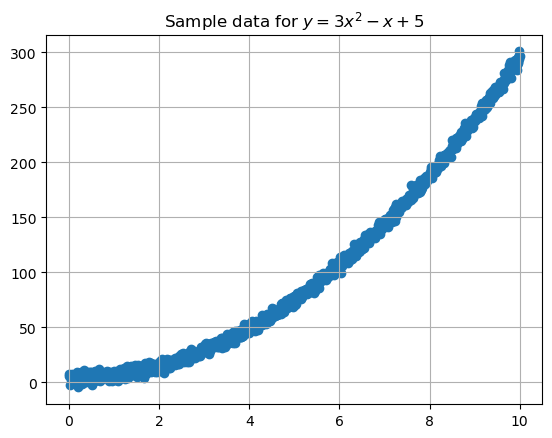

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings 
warnings.simplefilter("ignore")
import FoKL 

np.random.seed(20)

# Generate data 
x = np.linspace(0, 10, 1000)
y = 3 * x**2 - x + 5 + np.random.normal(loc = 0,scale=3, size=1000)

# Define the normal probability density function (PDF)
def normal_pdf(x, mean, std):
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))

# Define the quadratic model
def model(x, a, b, c):
    return a * x**2 + b * x + c

plt.title('Sample data for ' + r'$y=3x^2-x+5$')
plt.scatter(x,y)
plt.grid()


The formula below is integral to the likelihood calculation when fitting a model to data using the Metropolis-Hastings algorithm. This formula is derived from fundamental principles of probability and statistics, specifically Bayesian inference and the properties of the normal distribution. 
$$
normal PDF(y,\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}exp(-\frac{(y-\sigma)^2}{2\sigma^2})
$$
In the context of Bayesian inference, the likelihood of observing the data is given the model parameters is calculated. For normally distributed errors, the log-likelihood for a set of observations $(x_i,y_i)$, converting the product into sum is: 
$$ 
logL(a,b,c) = \sum^{n}_{i=1} log(\frac{1} {\sigma\sqrt{2\pi}}  exp( -\frac{(y_i - f(x_i; a,b,c))^2}{2\sigma^2}))
$$

This simplifies into: 
$$
logL(a,b,c) = -nlog(\sigma \sqrt{2\pi}) - \frac{1}{2\sigma^2} \sum^{n}_{i=1} (y_i - f(x_i; a,b,c))^2
$$

Since $-nlog(\sigma \sqrt{2\pi})$ is constant, it can be ignored for comparison purposes, leading to:
$$
logL(a,b,c) \propto - \frac{1}{2\sigma^2} \sum^{n}_{i=1} (y_i - f(x_i; a,b,c))^2
$$



In [2]:
# Initial values (can be random or zeros)
a, b, c = np.random.uniform(-1, 1, 3)

max_likelihood = -float('inf')
epsilon = 1e-10
iterations = 10000
std_dev = 5

# Best coefficients initialization
best_a, best_b, best_c = a, b, c


First, the Metropolis-Hastings algorithm is used to sample from the posterior distribution of the model parameters. We start with initial values of a,b,c and compute the initial likelihood. Then we move on to proposal step where 

$$
a' = a + N(0, \sigma_{proposal})
$$
$$
b' = b + N(0, \sigma_{proposal})
$$
$$
c' = c + N(0, \sigma_{proposal})
$$


Second, compute the likelihood of the proposed parameters by calculating the predicted $y$ values 

$$
y'_{pred} = f(x;a',b',c')
$$

compute the log-likelihood of the proposed parameters:

$$
logL(a,b,c) = \sum^n_{i=1}log(normal_pdf(y_i, y'_{pred_i},\sigma))
$$


Third, compute the acceptance probability 

$$
\alpha = exp(logL(a',b',c') - logL(a,b,c))
$$

Fourth is to accept or reject the new parameter by draw from uniform random number $u$. If $u <$ acceptance probability, accept the new parameter $(a,b,c \leftarrow a',b',c')$. If the new likelihood is higher than the current likelihood, always accept the new parameters.

In [3]:
trace_a = []
trace_b = []
trace_c = []


for i in range(iterations):
     # Proposal step: generate new candidate coefficients
     a_new = a + np.random.normal(0, 0.5)
     b_new = b + np.random.normal(0, 0.5)
     c_new = c + np.random.normal(0, 0.5)
     # Compute the predicted y values and the likelihood
     y_pred_new = model(x, a_new, b_new, c_new)
     pdf_values_new = normal_pdf(y, y_pred_new, std_dev)
     likelihood_new = np.sum(np.log(pdf_values_new + epsilon))

     # Compute the acceptance probability
     y_pred = model(x, a, b, c)
     pdf_values = normal_pdf(y, y_pred, std_dev)
     likelihood = np.sum(np.log(pdf_values + epsilon))

     # Compute the acceptance probability
     acceptance_prob = np.exp(likelihood_new - likelihood)

     # Accept or reject the new state
     if likelihood_new > likelihood or np.random.uniform(0, 1) < acceptance_prob:
         a, b, c = a_new, b_new, c_new
         if likelihood_new > max_likelihood:
             max_likelihood = likelihood_new
             best_a, best_b, best_c = a_new, b_new, c_new

     trace_a.append(best_a)
     trace_b.append(best_b)
     trace_c.append(best_c)
     
print(f"Best coefficients: a = {best_a}, b = {best_b}, c = {best_c}")
print(f"Maximum likelihood: {max_likelihood}")


Best coefficients: a = 3.0123203381599915, b = -1.1061989925335336, c = 5.030593554990187
Maximum likelihood: -2702.379286342489


Best coefficients: a = 3.0123203381599915, b = -1.1061989925335336, c = 5.030593554990187


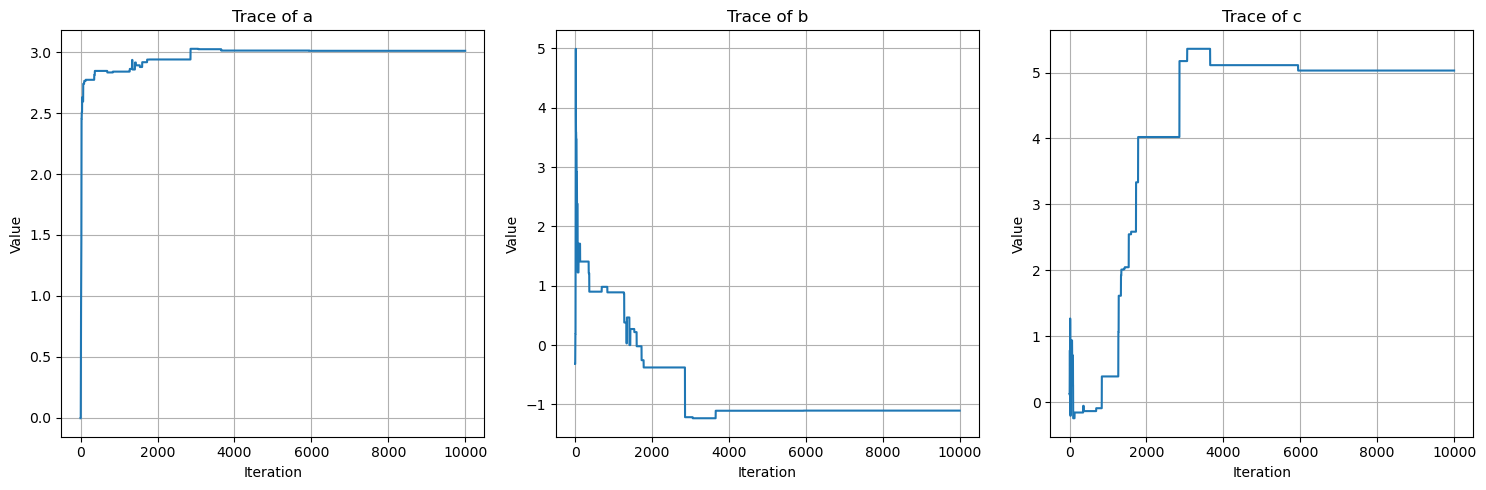

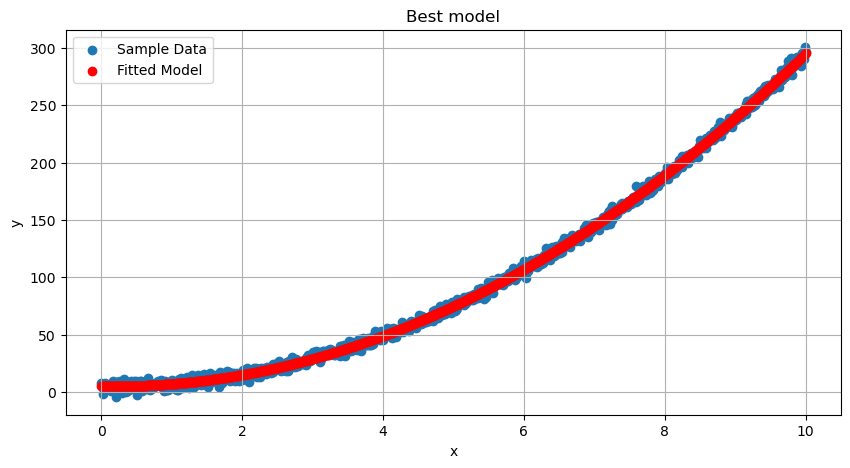

In [4]:
print(f"Best coefficients: a = {best_a}, b = {best_b}, c = {best_c}")

# Plot the trace of the coefficients
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(trace_a, label='a')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace of a')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(trace_b, label='b')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace of b')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(trace_c, label='c')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace of c')
plt.grid()

plt.tight_layout()
plt.show()

# Plot the final fitted model with the sample data
plt.figure(figsize=(10, 5))
plt.title('Best model')
plt.scatter(x, y, label='Sample Data')
plt.scatter(x, model(x, best_a, best_b, best_c), color='red', label='Fitted Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

This code visualizes the MCMC process, demonstrating how the parameters change over iterations and how the final model fits the data. The process involves proposing new coefficients a, b, and c, and calculating the likelihood of these new coefficients. By comparing this new likelihood with the current likelihood, we determine whether to accept the new coefficients. Initially, there is significant fluctuation in the values of all three coefficients. Over time, these fluctuations decrease, and the values stabilize, indicating that the algorithm has identified the best coefficients. This stabilization is reflected in the straightening of the trace lines, showing convergence to the optimal parameters.